In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import os
import cv2 as cv
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

In [ ]:
from pathlib import Path
import imghdr

data_dir = "/content/drive/MyDrive/Waste_Classification"
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

In [ ]:
batch_size = 50
img_height = 256
img_width = 256

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1176 files belonging to 8 classes.
Using 941 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1176 files belonging to 8 classes.
Using 235 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Aluminium', 'Glass', 'Organic Waste', 'Other Plastics', 'Paper and Cardboard', 'Plastic', 'Textiles', 'Wood']


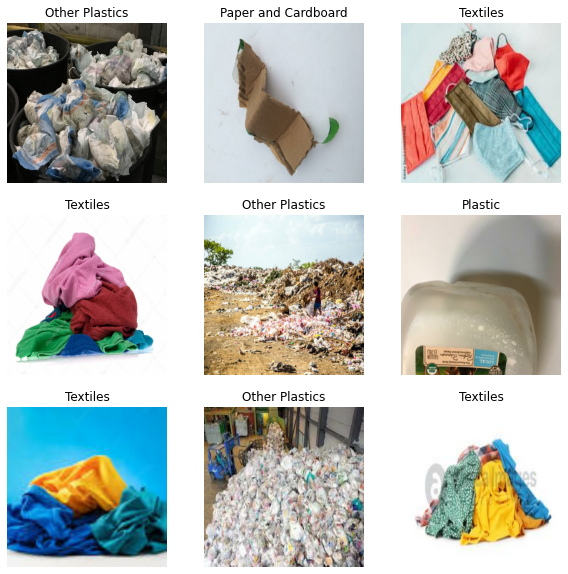

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(50, 256, 256, 3)
(50,)


In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs=12
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/12
19/19 [==============================] - 64s 3s/step - loss: 2.2574 - accuracy: 0.2880 - val_loss: 1.6461 - val_accuracy: 0.4511
Epoch 2/12
19/19 [==============================] - 58s 3s/step - loss: 1.4865 - accuracy: 0.4878 - val_loss: 1.2935 - val_accuracy: 0.5532
Epoch 3/12
19/19 [==============================] - 58s 3s/step - loss: 1.1049 - accuracy: 0.6153 - val_loss: 1.0282 - val_accuracy: 0.6596
Epoch 4/12
19/19 [==============================] - 58s 3s/step - loss: 0.8035 - accuracy: 0.7407 - val_loss: 0.9902 - val_accuracy: 0.6553
Epoch 5/12
19/19 [==============================] - 58s 3s/step - loss: 0.5990 - accuracy: 0.8087 - val_loss: 0.9878 - val_accuracy: 0.6596
Epoch 6/12
19/19 [==============================] - 58s 3s/step - loss: 0.4439 - accuracy: 0.8672 - val_loss: 1.2741 - val_accuracy: 0.6213
Epoch 7/12
19/19 [==============================] - 58s 3s/step - loss: 0.3151 - accuracy: 0.9097 - val_loss: 1.0834 - val_accuracy: 0.6766
Epoch 8/12
19/19 [==

In [ ]:
model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_11 (Rescaling)    (None, 256, 256, 3)       0         
                                                                 
 conv2d_58 (Conv2D)          (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 128, 128, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_59 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_60 (Conv2D)          (None, 64, 64, 64)      

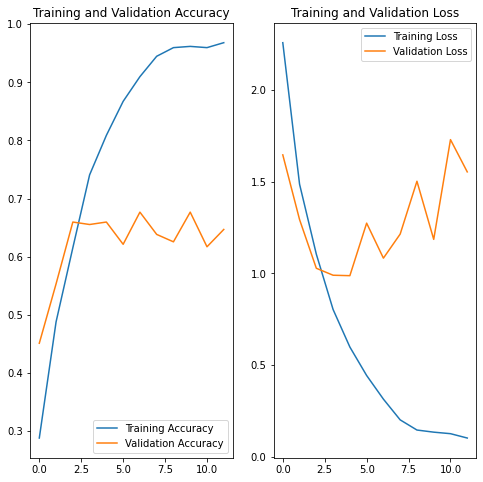

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
path = '/content/drive/MyDrive/Waste_Classification/Aluminium/Aluminium (1).jpg'

img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Aluminium with a 96.58 percent confidence.


In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

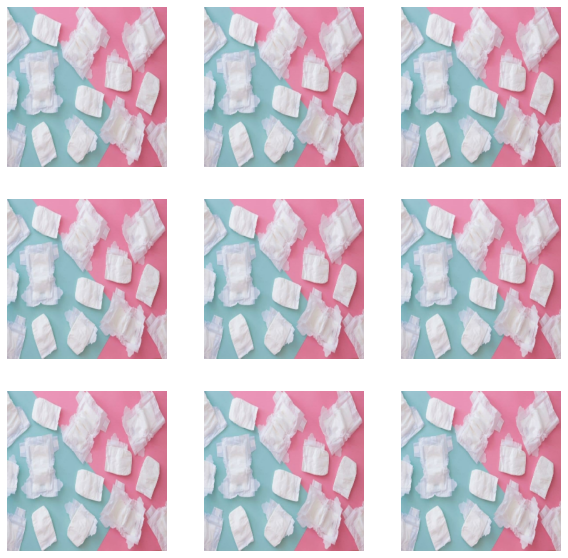

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation = 'softmax')
])

In [ ]:
model.compile(optimizer='adam',
              loss='SparseCategoricalCrossentropy',
              metrics=['accuracy'])

In [ ]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
19/19 [==============================] - 70s 4s/step - loss: 2.6892 - accuracy: 0.1838 - val_loss: 1.7806 - val_accuracy: 0.3362
Epoch 2/10
19/19 [==============================] - 72s 4s/step - loss: 1.6636 - accuracy: 0.4091 - val_loss: 1.4911 - val_accuracy: 0.4936
Epoch 3/10
19/19 [==============================] - 68s 4s/step - loss: 1.3738 - accuracy: 0.4973 - val_loss: 1.2427 - val_accuracy: 0.5957
Epoch 4/10
19/19 [==============================] - 68s 4s/step - loss: 1.2774 - accuracy: 0.5760 - val_loss: 1.1651 - val_accuracy: 0.6255
Epoch 5/10
19/19 [==============================] - 67s 4s/step - loss: 1.1472 - accuracy: 0.6036 - val_loss: 1.1755 - val_accuracy: 0.6340
Epoch 6/10
19/19 [==============================] - 70s 4s/step - loss: 1.1346 - accuracy: 0.5930 - val_loss: 1.2159 - val_accuracy: 0.5660
Epoch 7/10
19/19 [==============================] - 67s 4s/step - loss: 1.0823 - accuracy: 0.6174 - val_loss: 1.1469 - val_accuracy: 0.6638
Epoch 8/10
19/19 [==

In [ ]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_10 (Sequential)  (None, 256, 256, 3)       0         
                                                                 
 rescaling_7 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 128, 128, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                

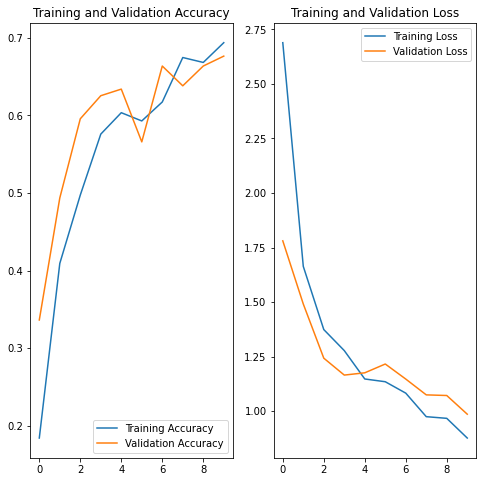

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
path = '/content/drive/MyDrive/Waste_Classification/Plastic/Plastic (10).jpg'

img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Plastic with a 97.15 percent confidence.
